In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import time
from ml_metrics import apk as apk, mapk as mapk
from itertools import product
from collections import OrderedDict
import gc

from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('fivethirtyeight')

# Preprocessing

## Functions for validation

In [2]:
# custom AP@K metrics
def ap_k(arr1, arr2, k):

    mean_k=[]
    sim = list(map(lambda x: x[0] == x[1] , zip(arr1,arr2)))
    
    for i in range(1,k+1):
        time_arr = sim[:i]
        tr = time_arr.count(True)
        fp = time_arr.count(False)
        mean_k.append(tr/(tr+fp))
        
    return np.mean(mean_k)

In [3]:
# custom MAP@K metrics
def map_k(actual, predicted, k):
    return np.mean([ap_k(a,p,k) for a,p in zip(actual, predicted)])

In [4]:
# functions used to compare our predicts with our test set
# custom MAP@K and ml_metrics' MAP@K used
# NaN values filled from top_5 most popular shows
def test_mapk(df_X, df_y, top_5, check_sets=True):

    test_set = df_y.copy()
    test_set = test_set.join(df_X, on='user_id', how='left', rsuffix='_pred')
    fillna_with_top(test_set, 'tv_show_id_pred', top_5)
    
    if check_sets:
        assert (test_set['tv_show_id'].apply(lambda x: len(set(x)) != len(x)).mean()) == 0
        assert (test_set['tv_show_id'].isna().sum()) == 0
        assert ((test_set['tv_show_id'].apply(len) != 5).mean()) == 0
        assert (test_set['tv_show_id_pred'].isna().sum()) == 0
        assert (test_set['tv_show_id_pred'].apply(lambda x: len(set(x)) != len(x)).mean()) == 0
        assert ((test_set['tv_show_id_pred'].apply(len) != 5).mean()) == 0

    print("MAPK:", mapk(test_set['tv_show_id'], test_set['tv_show_id_pred'], 5))
    print("MAP_K:", map_k(test_set['tv_show_id'], test_set['tv_show_id_pred'], 5))

## Functions for calculating statistics

In [5]:
# most popular shows by user
def top_user_show(df):        
    return df.groupby('user_id')['tv_show_id'].value_counts().reset_index(name='count').groupby(
        'user_id').head(5).groupby(
        'user_id')['tv_show_id'].apply(list).to_frame()

In [6]:
# most popular shows by user with sorted shows by their overall popularity
def top_user_show_sorted(df):
    
    res = df.copy()
    res = res.join(res.groupby(
        ['user_id', 'tv_show_id']).size().to_frame(name='u_s_cnt'), 
                   on=['user_id', 'tv_show_id'], how='left') 
    res = res.join(res.groupby(
        'tv_show_id').size().to_frame(name='global_cnt'),
                   on='tv_show_id', how='left')
    show_cnt = res.groupby(
        ['user_id', 'tv_show_id'])[['u_s_cnt', 'global_cnt']].mean().reset_index().sort_values(
        ['u_s_cnt', 'global_cnt'], ascending=False).groupby('user_id').head(5).groupby(
        'user_id')['tv_show_id'].apply(list).to_frame()
    
    return show_cnt   

In [7]:
# function that combines views of one show in one time period
# for example, when the user switched the channel and then returned
def full_intercept(df):
    df_full = df.groupby(['start_time_tv','channel_id','user_id'])['interception_time'].sum().reset_index()
    df_full.columns = ['start_time_tv', 'channel_id', 'user_id', 'full_interception_time']
    big_df = pd.merge(df_full, df, 
                      on=['start_time_tv', 'channel_id', 'user_id'])
    big_df_no_dub = big_df.drop_duplicates(
        subset=['start_time_tv', 'channel_id', 
                'user_id','full_interception_time']).drop(
        'interception_time', axis = 1)
    
    return big_df_no_dub

Functions for filling missing shows for user with most popular shows 

In [8]:
# calculate top shows overall
def top_shows(df, group_col, N):
    return df.groupby(group_col).size().sort_values(
        ascending=False).head(N).index.to_list()

In [9]:
def fillna_with_top(df, column, top):
    df[column] = df[column].apply(lambda x: top if x is np.nan else x)

In [10]:
# fill missing shows for each user
# OrderedDict used to save original order of shows for user
def fill_to_5(df, column, top):
    df[column] = df[column].apply(lambda x: x if len(x) == 5 else 
                                  list(OrderedDict.fromkeys((x + top)))[:5])

In [11]:
# similarity matrix from users' ratings
def create_similarity_matrix(df):
    pvt_table = pd.pivot_table(df, 
                               values='full_interception_time', 
                               columns=['tv_show_id'],
                               index=['user_id'],
                               aggfunc='count').fillna(0)
    pvt_table = pvt_table.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    cos_sim = cosine_similarity(pvt_table)
    np.fill_diagonal(cos_sim, 0)
    cos_sim = pd.DataFrame(cos_sim, 
                           index = pvt_table.index, 
                           columns = pvt_table.index)

    return pvt_table, cos_sim

In [12]:
# find most popular shows among similar users for user_id
def similar_shows(cos_sim_matrix, pvt_table, user_id, n_shows):
    similar_user = cos_sim_matrix[user_id].nlargest(10).index
    similar_user_ratings = pvt_table.loc[similar_user].stack().reset_index(name='rating')
    similar_user_top = similar_user_ratings.sort_values('rating', ascending=False).groupby(
        'user_id').head(10)
    similar_shows = similar_user_top.groupby('tv_show_id')['rating'].sum().nlargest(n_shows)
    
    return similar_shows.index.to_list()

In [13]:
# filling missing shows for each user with similar users' shows
# OrderedDict used to save original order of shows for user
def fill_with_recommend(df, column, cos_sim_matrix, pvt_table):
    df[column] = df.apply(lambda x: x[column] if len(x[column]) == 5 else 
                          list(OrderedDict.fromkeys((
                              x[column] + 
                              similar_shows(cos_sim_matrix, pvt_table, x['user_id'], 10))))[:5], axis=1)

## Data reading and cleaning

In [14]:
FULL_DATA_DIR = '/kaggle/input/sweet-data'
DATA_DIR = '/kaggle/input/sweettv-tv-program-recommender'

big_data_df = pd.read_csv(os.path.join(FULL_DATA_DIR, 'big_data.csv'))
arh_1 = pd.read_csv(os.path.join(DATA_DIR, 'export_arh_11-20-final.csv'))
arh_2 = pd.read_csv(os.path.join(DATA_DIR, 'export_arh_21-30-final.csv'))
test_arh = pd.read_csv(os.path.join(DATA_DIR, 'export_arh_31-42-final.csv'))
submission = pd.read_csv(os.path.join(DATA_DIR, 'submission.csv'))

arh = pd.concat([arh_1, arh_2], axis=0)
train_arh = arh[arh['tv_show_id'] != 0].reset_index(drop=True).copy()
test_arh = test_arh[test_arh['tv_show_id'] != 0].reset_index(drop=True).copy()

uniq_train = np.setdiff1d(train_arh['tv_show_id'].unique(), test_arh['tv_show_id'].unique())
big_data_df = big_data_df[~big_data_df['tv_show_id'].isin(uniq_train)]
train_arh = train_arh[~train_arh['tv_show_id'].isin(uniq_train)]

del arh, arh_1, arh_2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
big_data_df.columns = ['channel_id', 'start_time_tv', 'tv_show_id', 'stop_time_tv', 'trunk_day',
                       'user_id', 'vsetv_id', 'start_time_user', 'stop_time_user', 'interception_time']
big_data_df.drop(columns=['trunk_day', 'vsetv_id'], inplace=True)

dt_format = "%Y-%m-%d %H:%M:%S"
big_data_df['start_time_tv'] = pd.to_datetime(big_data_df['start_time_tv'], format=dt_format)
big_data_df['stop_time_tv'] = pd.to_datetime(big_data_df['stop_time_tv'], format=dt_format)
big_data_df['start_time_user'] = pd.to_datetime(big_data_df['start_time_user'], format=dt_format)
big_data_df['stop_time_user'] = pd.to_datetime(big_data_df['stop_time_user'], format=dt_format)
train_arh['start_time'] = pd.to_datetime(train_arh['start_time'], format='%d.%m.%Y %H:%M:%S')
test_arh['start_time'] = pd.to_datetime(test_arh['start_time'], format='%d.%m.%Y %H:%M:%S')

big_data_df['duration'] = (big_data_df['stop_time_tv'] - big_data_df['start_time_tv']).dt.seconds
big_data_df['view_pct'] = (big_data_df['interception_time'] / big_data_df['duration'])
big_data_df['view_pct'].clip(0, 1, inplace=True)

train_df = full_intercept(big_data_df)

show_cat = train_arh[['tv_show_id', 'tv_show_category']].drop_duplicates().set_index('tv_show_id')
train_df = train_df.join(show_cat, on='tv_show_id', how='left')

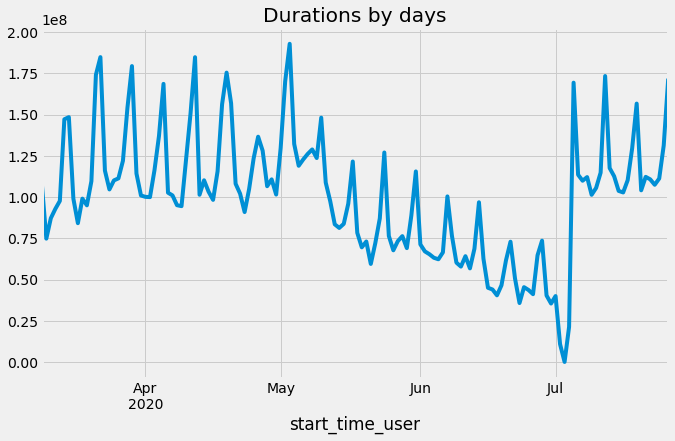

In [16]:
train_df.groupby([pd.Grouper(key='start_time_user', 
                             freq='D')])['duration'].sum().plot(figsize=(10, 6))
plt.title("Durations by days")
plt.show()

['Инфо' 'Фильмы' 'Сериалы' 'Развлечения' 'Познавательное' 'Другое' 'Детям']
['Развлечения' 'Инфо' 'Сериалы' 'Фильмы' 'Познавательное' 'Другое' 'Детям'
 'Спорт']


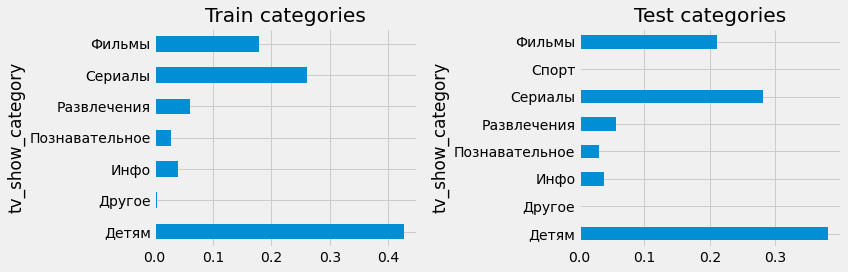

In [17]:
print(train_arh['tv_show_category'].unique())
print(test_arh['tv_show_category'].unique())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

(train_arh.groupby('tv_show_category')['tv_show_id'].count() / 
 train_arh.shape[0]).plot(kind='barh', ax=ax[0])
ax[0].set_title("Train categories")
(test_arh.groupby('tv_show_category')['tv_show_id'].count() / 
 test_arh.shape[0]).plot(kind='barh', ax=ax[1])
ax[1].set_title("Test categories")

plt.tight_layout()
plt.show()

Percent of shows with more than one channel 0.5724177726485863


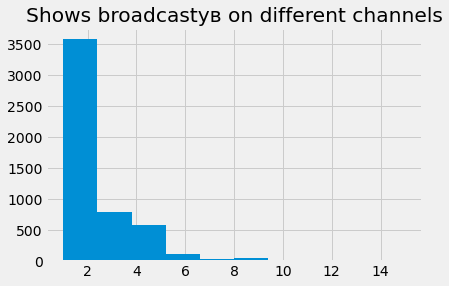

In [18]:
print("Percent of shows with more than one channel", 
      (train_arh.groupby('tv_show_id')['channel_id'].nunique() > 1).mean())
(train_arh.groupby('tv_show_id')['channel_id'].nunique()).hist()
plt.title("Shows broadcastув on different channels")
plt.show()

# Testing

## Split data by train/test

In [19]:
final_df_X = train_df[train_df['start_time_user'].dt.month != 7].copy()
final_df_y = train_df[train_df['start_time_user'].dt.month == 7].copy()

test_set = top_user_show(final_df_y[final_df_y['view_pct'] >= 0.8])
test_set = test_set[test_set['tv_show_id'].apply(len) == 5]

print("Duplicates in shows -", test_set['tv_show_id'].apply(lambda x: len(set(x)) != len(x)).mean())
print("NaNs in shows -", test_set['tv_show_id'].isna().sum())
print("Missing shows -", (test_set['tv_show_id'].apply(len) != 5).mean())

Duplicates in shows - 0.0
NaNs in shows - 0
Missing shows - 0.0


In [20]:
# how many times each user watched TV
def prepare_time_df(df):
    agg_df = df.groupby(['day_of_week', 'hour', 'user_id'])['interception_time'].count().reset_index()
    
    agg_df['week_hour'] = agg_df['day_of_week'].astype(str) + '_' + agg_df['hour'].astype(str)
    
    agg_df_piv = pd.pivot_table(agg_df[['user_id', 'interception_time', 'week_hour']], 
                   values='interception_time', 
                   columns=['user_id'],
                   index=['week_hour']).fillna(0)
    
    scaler = MinMaxScaler()
    
    df_agg_piv_sc = pd.DataFrame(scaler.fit_transform(agg_df_piv), 
                             index = agg_df_piv.index, 
                             columns = agg_df_piv.columns)
    
    return df_agg_piv_sc

In [21]:
# rating of the show calculated by user matrix
def prepare_show_df(df):
    agg_df = df.groupby(['tv_show_id', 'user_id'])['interception_time'].count().reset_index()
    agg_df_piv = pd.pivot_table(agg_df, 
                       values='interception_time', 
                       columns=['user_id'],
                       index=['tv_show_id']).fillna(0)
    scaler = MinMaxScaler()

    df_agg_piv_sc = pd.DataFrame(scaler.fit_transform(agg_df_piv), 
                                 index = agg_df_piv.index, 
                                 columns = agg_df_piv.columns)
    return df_agg_piv_sc

In [22]:
df = pd.read_csv('/kaggle/input/sweet-data/crop_data_1.csv')

df.start_time_tv = pd.to_datetime(df.start_time_tv)
df.stop_time_tv = pd.to_datetime(df.stop_time_tv)

df['day_of_week'] = df.start_time_tv.dt.dayofweek
df['hour'] = df.start_time_tv.dt.hour

df.head()

,channel_id,start_time_tv,duration,tv_show_id,stop_time_tv,user_id,vsetv_id,start_time_user,stop_time_user,interception_time,day_of_week,hour
0,3,2020-03-13 00:50:00,600,2400480,2020-03-13 01:00:00,13245325954936692066,3,2020-03-13 00:02:08,2020-03-13 01:48:36,600.0,4,0
1,3,2020-03-13 00:50:00,600,2400480,2020-03-13 01:00:00,2674242068734372740,3,2020-03-13 00:04:50,2020-03-13 00:50:14,14.0,4,0
2,3,2020-03-13 00:50:00,600,2400480,2020-03-13 01:00:00,13638882539922173677,3,2020-03-13 00:07:07,2020-03-13 02:08:59,600.0,4,0
3,3,2020-03-13 00:50:00,600,2400480,2020-03-13 01:00:00,3907354689415233903,3,2020-03-13 00:09:01,2020-03-13 01:23:19,600.0,4,0
4,3,2020-03-13 00:50:00,600,2400480,2020-03-13 01:00:00,10014349624473638912,3,2020-03-13 00:13:59,2020-03-13 00:50:43,43.0,4,0


In [23]:
show_df = prepare_show_df(df)
show_df.head()

user_id,2244466330591177,3767274164463716,22263144883588864,25263373097189844,36938861791891792,37747430840118209,40421401857115442,44032390614277934,52369349052901997,54521601679629335,...,18417531283109304442,18418581976329388680,18420447773506519613,18423558708285759863,18432742752712514319,18436538545025490822,18437797701155742162,18438926380372621167,18440717181607000261,18443832178892490378
tv_show_id,,,,,,,,,,,,,,,,,,,,,
20088,0.0,0.166667,0.0,1.0,0.543478,0.384615,0.538462,0.384615,0.571429,0.111111,...,0.017857,0.066667,0.0,0.0,0.0,0.000000,1.0,0.0,1.0,0.0
52641,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
100035,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
100045,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
100055,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.006289,0.0,0.0,0.0,0.0


In [24]:
time_df = prepare_time_df(df)
time_df.head()

user_id,2244466330591177,3767274164463716,22263144883588864,25263373097189844,36938861791891792,37747430840118209,40421401857115442,44032390614277934,52369349052901997,54521601679629335,...,18417531283109304442,18418581976329388680,18420447773506519613,18423558708285759863,18432742752712514319,18436538545025490822,18437797701155742162,18438926380372621167,18440717181607000261,18443832178892490378
week_hour,,,,,,,,,,,,,,,,,,,,,
0_0,0.000000,0.000000,0.133333,0.166667,0.000000,0.043478,0.00,0.521739,0.222222,0.0,...,0.000000,0.076923,0.0000,0.090909,0.0,0.000000,0.228571,0.000000,0.0000,0.000000
0_1,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.00,0.086957,0.000000,0.0,...,0.000000,0.230769,0.0000,0.181818,0.0,0.000000,0.114286,0.000000,0.0000,0.000000
0_10,0.166667,0.142857,0.000000,0.000000,0.041667,0.173913,0.00,0.086957,0.000000,0.0,...,0.339623,0.307692,0.1250,0.000000,0.0,0.185185,0.200000,0.071429,0.1250,0.000000
0_11,0.000000,0.142857,0.666667,0.055556,0.166667,0.347826,0.00,0.391304,0.222222,0.0,...,0.037736,0.230769,0.5000,0.000000,0.2,0.111111,0.085714,0.357143,0.0625,0.166667
0_12,0.166667,0.250000,0.800000,0.000000,0.083333,0.217391,0.25,0.565217,0.000000,0.0,...,1.000000,0.230769,0.0625,0.000000,0.2,0.185185,0.314286,0.428571,0.0625,0.000000


## Сalculation of view rating

In [25]:
# calculating shows' ratings for the user based on screen time and show's age
final_df_X['view_rating'] = final_df_X['view_pct'].apply(lambda x: 5 if x==1
                                                         else 2 + 9*x**2)
T = 60
cont = 0.4
t_ref = (final_df_X['start_time_tv']).max()
final_df_X['view_rating'] = (final_df_X['view_rating'] * 
                             np.power(cont, (t_ref - final_df_X['start_time_tv']).dt.days / T))

In [26]:
# using different datasets to test our methods
final_df_X_08 = final_df_X[(final_df_X['view_pct'] >= 0.8)]
final_df_X_08_cat = final_df_X_08[final_df_X_08['tv_show_category'].isin(['Развлечения', 'Инфо', 
                                                                          'Сериалы', 'Детям', 
                                                                          'Познавательное', 
                                                                          'Другое'])]

final_df_X_08_cat_dur = final_df_X_08_cat[(final_df_X_08_cat['duration'] < 10000)]

In [27]:
show_cnt_X_08_cat = top_user_show_sorted(final_df_X_08_cat)
show_cnt_X_08_cat_dur = top_user_show(final_df_X_08_cat_dur)
show_cnt_new = top_user_show_sorted(final_df_X_08_cat_dur)

In [28]:
# top shows used for filling NaNs and other missing data
top_5_shows = top_shows(final_df_X_08_cat, 'tv_show_id', 5)
top_10_shows = top_shows(final_df_X_08_cat, 'tv_show_id', 10)

In [29]:
X = {'show_cnt_new': show_cnt_new,
     'final_df_X_08_cat_cnt': show_cnt_X_08_cat}


for name, ds_X in X.items():
    print(name)
    print("Duplicates in shows -", ds_X['tv_show_id'].apply(lambda x: len(set(x)) != len(x)).mean())
    print("NaNs in shows -", ds_X['tv_show_id'].isna().sum())
    print("Missing shows -", (ds_X['tv_show_id'].apply(len) != 5).mean())
    print()
    
    
for name, ds_X in X.items():
    fillna_with_top(ds_X, 'tv_show_id', top_5_shows)
    fill_to_5(ds_X, 'tv_show_id', top_10_shows)

show_cnt_new
Duplicates in shows - 0.0
NaNs in shows - 0
Missing shows - 0.12590233545647558

final_df_X_08_cat_cnt
Duplicates in shows - 0.0
NaNs in shows - 0
Missing shows - 0.1256900212314225



In [30]:
for name, ds_X in X.items():
    print(name)
    test_mapk(ds_X, test_set, top_5_shows)
    print()

show_cnt_new
MAPK: 0.3268764711902569
MAP_K: 0.22853546208167025

final_df_X_08_cat_cnt
MAPK: 0.32679561969092213
MAP_K: 0.22850271210725617



## Final solution

In [31]:
train_df['view_rating'] = train_df['view_pct'].apply(lambda x: 5 if x==1
                                                     else 2 + 2*x**2)
T = 60
cont = 0.8
t_ref = (train_df['start_time_tv']).max()
train_df['view_rating'] = (train_df['view_rating'] * 
                           np.power(cont, (t_ref - train_df['start_time_tv']).dt.days / T))

In [32]:
# Shows with high screen time and duration less than 10000
# Category "Фильмы" dropped
high_frequency_df = train_df[(train_df['view_pct'] >= 0.8) &
                             (train_df['duration'] < 10000)]

high_frequency_df_cat = high_frequency_df[high_frequency_df['tv_show_category'].isin(
    ['Развлечения', 'Инфо', 'Сериалы', 'Детям', 'Другое', 'Познавательное'])]

Top shows and cosine similarity matrix to fill missing shows for the user

In [33]:
top_5_shows = top_shows(high_frequency_df_cat, 'tv_show_id', 5)
top_10_shows = top_shows(high_frequency_df_cat,'tv_show_id', 10)
pvt_table, cos_sim_matrix = create_similarity_matrix(high_frequency_df_cat)

Calculation of the most popular shows for the user with respect to ratings and train/test show ratio

In [34]:
def counts(df):
    count_by_user_show = df.groupby(['user_id', 'tv_show_id'])['view_rating'].size().reset_index()
    rating_by_user_show = df.groupby(['user_id', 'tv_show_id'])['view_rating'].mean().reset_index()

    return count_by_user_show, rating_by_user_show

In [35]:
count_by_user_show, rating_by_user_show = counts(high_frequency_df_cat)
test_count = test_arh.groupby(['tv_show_id']).size().reset_index(name='test_count')
train_count = train_arh.groupby(['tv_show_id']).size().reset_index(name='train_count')

rating_by_user_show['count'] = count_by_user_show['view_rating']
rating_by_user_show = pd.merge(rating_by_user_show, train_count, 
                               on='tv_show_id', how='left')
rating_by_user_show = pd.merge(rating_by_user_show, test_count, 
                               on='tv_show_id', how='left')
rating_by_user_show['train_total'] = (rating_by_user_show['count'] * 
                                      rating_by_user_show['view_rating'] * 
                                      np.log10(rating_by_user_show['train_count']))

rating_by_user_show = rating_by_user_show.join(rating_by_user_show.groupby(
    'tv_show_id').size().to_frame(name='global_cnt'),
                                               on='tv_show_id', how='left')

show_user_rating = rating_by_user_show.sort_values(['train_total', 'global_cnt'], 
                                                   ascending=False).groupby(
    'user_id').head(5).groupby('user_id')['tv_show_id'].apply(list).to_frame()

In [36]:
show_cnt_user = top_user_show_sorted(high_frequency_df_cat)

my_submission = submission[['user_id']].join(show_user_rating, on='user_id', how='left')
print("NaNs in shows before fill -", my_submission['tv_show_id'].isna().sum())
fillna_with_top(my_submission, 'tv_show_id', top_5_shows)
print("Duplicates in shows -", my_submission['tv_show_id'].apply(lambda x: len(set(x)) != len(x)).mean())
print("Missing shows before fill -", (my_submission['tv_show_id'].apply(len) != 5).mean())
fill_with_recommend(my_submission, 'tv_show_id', cos_sim_matrix, pvt_table)
assert (my_submission['tv_show_id'].apply(len) != 5).mean() == 0

NaNs in shows before fill - 10
Duplicates in shows - 0.0
Missing shows before fill - 0.03253968253968254


In [37]:
my_submission['tv_show_id'] = my_submission['tv_show_id'].apply(lambda x: ' '.join([str(i) for i in x]))
my_submission.to_csv('/kaggle/working/my_submission.csv', index=False)
my_submission

,user_id,tv_show_id
0,8377619604347126107,2400480 12002955 2400508 240081 12002896
1,8381667675275833309,2400480 240081 200344 12001682 500346
2,8387147770138767246,12001682 12002856 12001732 12002955 12002771
3,8397181578236218580,2400480 20088 240081 6700482 2400467
4,8404698046253197367,2400480 240081 10003012 20088 6200371
...,...,...
1255,10876606683805171865,2400480 12001712 10001514 12001682 1000376
1256,10886096340955133676,12001682 12001734 12002856 2400480 10001514
1257,10902911550446151928,12001682 240081 12001734 12002856 2400480
1258,10904697592493678571,12001682 240081 12001734 2400480 12002896
